# Time series analysis for QIN, WA state, and WA state shelf region

Daisy's script

In [5]:
# import libraries
import numpy as np
import pandas as pd
#import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import seaborn as sns
import warnings
warnings.simplefilter('ignore') # filter some warning messages

In [6]:
def poly_mask(data, polygon):
    import pylab as plt
    from matplotlib.path import Path

    ds=data
    mask_0=ds[var][0,:,:]/ds[var][0,:,:]
    #mask_0[:]=0
    width, height=len(mask_0.lon), len(mask_0.lat)
    #print(mask_0)

    polygon=polygon 
    poly_path=Path(polygon)

    x, y = np.meshgrid(mask_0.lon, mask_0.lat)
    coors=np.hstack((x.reshape(-1, 1), y.reshape(-1,1))) # coors.shape is (4000000,2)
    mask_values = poly_path.contains_points(coors).reshape(height, width)    
    mask = xr.DataArray(mask_values*mask_0,                                 
                  name='polygon_mask',             
                  coords={'lat':mask_0.lat,'lon':mask_0.lon},    
                  dims=('lat','lon') )
    mask=mask.where(mask==1,0)
    #plt.imshow(mask)
    #plt.contourf(mask.lon,mask.lat,mask,15)
    lat1 = int(np.floor(ds.lat[0].data))
    lat2 = int(np.ceil(ds.lat[-1].data))
    lon1 = int(np.floor(ds.lon[0].data))
    lon2 = int(np.ceil(ds.lon[-1].data))
    plt.figure(figsize=(8,6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines(resolution='50m',linewidth=1,color='black',alpha=0.8,zorder=1)

    ax.set_extent([220,244,31,49],crs=ccrs.PlateCarree())
    ax.set_xticks([-140,-135,-130,-125,-120,-115], crs=ccrs.PlateCarree())
    ax.set_yticks([35,40,45], crs=ccrs.PlateCarree())

    ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    plt.contourf(mask.lon,mask.lat,mask,15, cmap='RdBu', vmin=0, vmax=1)
    plt.colorbar(fraction=0.04, pad=0.05)
    ax.set_aspect(1.5)
    plt.show()
    
    return mask

In [7]:
def weighted_mean(data_in,data_cond):
    import numpy as np
    import xarray as xr
    #data_in = input xarray data to have weighted mean
    #data_mask = nan mask eg. land values
    #LME mask T or F values
    global_attrs = data_in.attrs
    R = 6.37e6 #radius of earth in m
    grid_dy,grid_dx = (data_in.lat[0]-data_in.lat[1]).data,(data_in.lon[0]-data_in.lon[1]).data
    dϕ = np.deg2rad(grid_dy)
    dλ = np.deg2rad(grid_dx)
    dA = R**2 * dϕ * dλ * np.cos(np.deg2rad(data_in.lat)) 
    pixel_area = dA.where(data_cond==1)
    sum_data=(data_in*pixel_area).sum(dim=('lon', 'lat'),keep_attrs=True, skipna=True)
    total_ocean_area = pixel_area.sum(dim=('lon', 'lat'))
    #print(sum_data)
    #print(total_ocean_area)
    data_weighted_mean = sum_data/total_ocean_area
    data_weighted_mean.attrs = global_attrs  #save global attributes
    for a in data_in:                      #set attributes for each variable in dataset
        gatt = data_in[a].attrs
        data_weighted_mean[a].attrs=gatt

    return data_weighted_mean

# Specify below the variable and location of variable you want to see

In [143]:
#specify variable and location of variable

#variable- 'thetao' 'o2' 
#location of variable- 'surface' 'bottom' 

var='thetao'
loc='bottom'
figdir='/Volumes/GoogleDrive/My Drive/QIN/figures/'

#directory for masks
mask_dir ='/Volumes/GoogleDrive/My Drive/QIN/masks/'

svar=loc +" "+ var
if var=='thetao':
    units='°C'
if var=='o2' :
    units='ml/l'
print(svar)

bottom thetao


In [144]:
#read observations
import glob
for fn in glob.glob('/Volumes/GoogleDrive/My Drive/QIN/data/GLORYS_timeseries_*'+loc+'_'+var+'*'):
    print  (fn)
    obs=xr.open_dataset(fn)
    obs.close()
obs=obs.sel(lat=slice(31.0 , 48.916668),lon=slice(220.0,244.91666 ))
obs

/Volumes/GoogleDrive/My Drive/QIN/data/GLORYS_timeseries_bottom_thetao_216x300.nc


<xarray.Dataset>
Dimensions:  (lat: 216, lon: 300, time: 312)
Coordinates:
  * time     (time) datetime64[ns] 1993-01-16T12:00:00 ... 2018-12-16T12:00:00
  * lat      (lat) float32 31.0 31.083334 31.166666 ... 48.833332 48.916668
  * lon      (lon) float32 220.0 220.08333 220.16667 ... 244.83334 244.91666
Data variables:
    thetao   (time, lat, lon) float64 ...
    depth    (lat, lon) float64 ...
    mask     (lat, lon) int64 ...

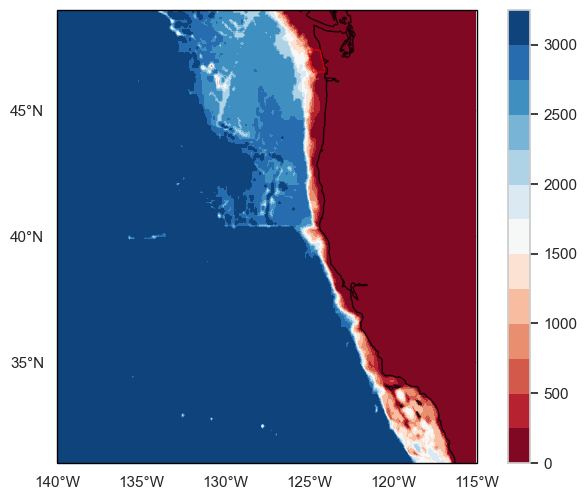

In [145]:
#identify shelf region 
shelf=300  #(depths less than 300 meters)
ds=obs.depth#.sel(lat=slice(45,49),lon=slice(-126+360,-123+360))#.where(obs.depth<=shelf)
lat1 = int(np.floor(ds.lat[0].data))
lat2 = int(np.ceil(ds.lat[-1].data))
lon1 = int(np.floor(ds.lon[0].data))
lon2 = int(np.ceil(ds.lon[-1].data))
plt.figure(figsize=(8,6) ,dpi=100)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='50m',linewidth=1,color='black',alpha=0.8,zorder=1)

ax.set_extent([220,244,31,49],crs=ccrs.PlateCarree())
ax.set_xticks([-140,-135,-130,-125,-120,-115], crs=ccrs.PlateCarree())
ax.set_yticks([35,40,45], crs=ccrs.PlateCarree())

qbox = np.array([[-124.05,-124.33,-125.07,-124.774,-124.05],[46.53,47.4,47.4,46.53,46.53]])
plt.plot(qbox[0,:],qbox[1,:],c='red',lw=1,zorder=4, alpha=0.7)

ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
ax.yaxis.set_major_formatter(LatitudeFormatter())
plt.contourf(ds.lon,ds.lat,ds,15, cmap='RdBu')#, vmin=0, vmax=1)
plt.colorbar(fraction=0.04, pad=0.05)

'''
CS = plt.contour(ds.lon,ds.lat,ds, levels=10,alpha=.8, linewidths=1, colors='k')
print(CS.levels)
CS.collections[0].set_linewidth(0) 
CS.collections[2].set_linewidth(0) 
CS.collections[3].set_linewidth(0) 
CS.collections[4].set_linewidth(0) 
CS.collections[5].set_linewidth(0) 
CS.collections[6].set_linewidth(0) 
CS.collections[7].set_linewidth(0) 
CS.collections[8].set_linewidth(0) 
CS.collections[9].set_linewidth(0) 
CS.collections[10].set_linewidth(0) 
CS.collections[11].set_linewidth(0) 
CS.collections[1].set_linewidth(2) 
'''
ax.set_aspect(1.5)
plt.show()




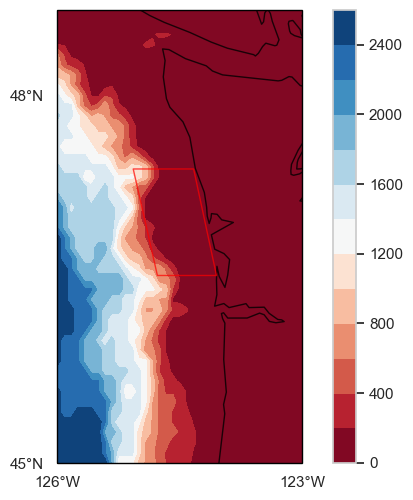

In [146]:
#identify shelf region 
shelf=300  #(depths less than 300 meters)
ds=obs.depth.sel(lat=slice(45,49),lon=slice(-126+360,-123+360))#.where(obs.depth<=shelf)
lat1 = int(np.floor(ds.lat[0].data))
lat2 = int(np.ceil(ds.lat[-1].data))
lon1 = int(np.floor(ds.lon[0].data))
lon2 = int(np.ceil(ds.lon[-1].data))
plt.figure(figsize=(8,6) ,dpi=100)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='50m',linewidth=1,color='black',alpha=0.8,zorder=1)

#ax.set_extent([220,244,31,49],crs=ccrs.PlateCarree())
#ax.set_xticks([-140,-135,-130,-125,-120,-115], crs=ccrs.PlateCarree())
#ax.set_yticks([35,40,45], crs=ccrs.PlateCarree())

ax.set_extent([-126+360,-123+360,45,48.7],crs=ccrs.PlateCarree())
ax.set_xticks([-126,-123], crs=ccrs.PlateCarree())
ax.set_yticks([45,48], crs=ccrs.PlateCarree())

qbox = np.array([[-124.05,-124.33,-125.07,-124.774,-124.05],[46.53,47.4,47.4,46.53,46.53]])
plt.plot(qbox[0,:],qbox[1,:],c='red',lw=1,zorder=4, alpha=0.7)

ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
ax.yaxis.set_major_formatter(LatitudeFormatter())
plt.contourf(ds.lon,ds.lat,ds,15, cmap='RdBu')#, vmin=0, vmax=1)
plt.colorbar(fraction=0.04, pad=0.05)

'''
CS = plt.contour(ds.lon,ds.lat,ds, levels=10,alpha=.8, linewidths=1, colors='k')
print(CS.levels)
CS.collections[0].set_linewidth(0) 
CS.collections[2].set_linewidth(0) 
CS.collections[3].set_linewidth(0) 
CS.collections[4].set_linewidth(0) 
CS.collections[5].set_linewidth(0) 
CS.collections[6].set_linewidth(0) 
CS.collections[7].set_linewidth(0) 
CS.collections[8].set_linewidth(0) 
CS.collections[9].set_linewidth(0) 
CS.collections[10].set_linewidth(0) 
CS.collections[11].set_linewidth(0) 
CS.collections[1].set_linewidth(2) 
'''
ax.set_aspect(1.5)
plt.show()



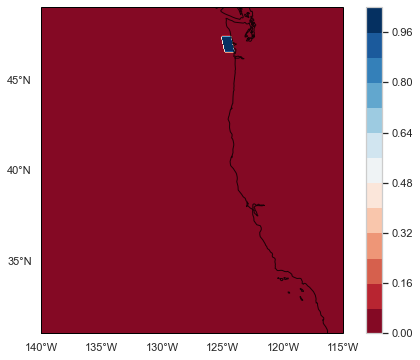

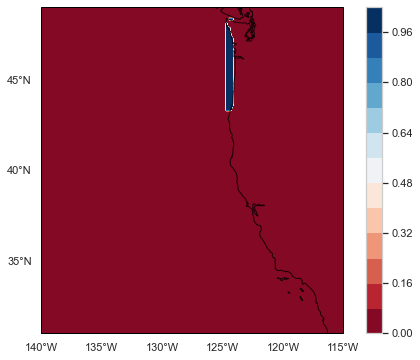

In [147]:
#create QIN, WA coast, and WA shelf masks
#QIN region
poly_qbox=[(-124.05+360,46.53),(-124.33+360,47.4),(-125.07+360,47.4),(-124.774+360,46.53)] 
qin_mask=poly_mask(obs, poly_qbox)
#qin_mask.to_netcdf(mask_dir+'qin_mask.nc')
#WA state
poly_wa=[(-124.14+360,43.26),(-124.14+360,48.39),(-124.74+360,48.39),(-124.74+360,43.26)]
wa_mask=poly_mask(obs, poly_wa)
#Shelf region (depths less than specified meters within WA state)
shelf_mask=wa_mask.where(obs.depth<=shelf,0)

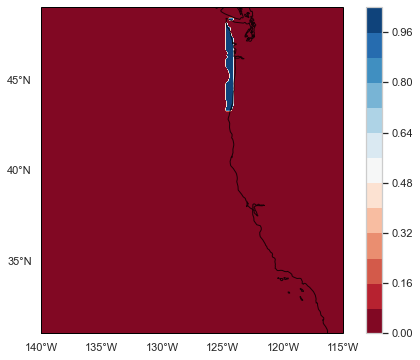

In [148]:
#check shelf region mask
ds=shelf_mask
lat1 = int(np.floor(ds.lat[0].data))
lat2 = int(np.ceil(ds.lat[-1].data))
lon1 = int(np.floor(ds.lon[0].data))
lon2 = int(np.ceil(ds.lon[-1].data))
plt.figure(figsize=(8,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='50m',linewidth=1,color='black',alpha=0.8,zorder=1)

ax.set_extent([220,244,31,49],crs=ccrs.PlateCarree())
ax.set_xticks([-140,-135,-130,-125,-120,-115], crs=ccrs.PlateCarree())
ax.set_yticks([35,40,45], crs=ccrs.PlateCarree())

ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
ax.yaxis.set_major_formatter(LatitudeFormatter())
plt.contourf(ds.lon,ds.lat,ds,15, cmap='RdBu')
plt.colorbar(fraction=0.04, pad=0.05)
ax.set_aspect(1.5)
plt.show()



<xarray.Dataset>
Dimensions:      (lat: 216, lon: 300, region: 1)
Coordinates:
  * region       (region) int64 2
  * lat          (lat) float64 31.0 31.08 31.17 31.25 ... 48.75 48.83 48.92
  * lon          (lon) float64 220.0 220.1 220.2 220.2 ... 244.8 244.8 244.9
Data variables:
    region_mask  (lat, lon) float64 ...
    geoname      object ...


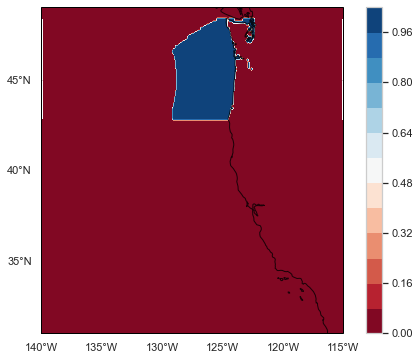

In [149]:
#read eez mask and check
fn=mask_dir+'eez_mask.nc'
ds_mask=xr.open_dataset(fn)
ds_mask.close()
print(ds_mask)
eez_mask=ds_mask.region_mask.load()
ds=eez_mask
lat1 = int(np.floor(ds.lat[0].data))
lat2 = int(np.ceil(ds.lat[-1].data))
lon1 = int(np.floor(ds.lon[0].data))
lon2 = int(np.ceil(ds.lon[-1].data))
plt.figure(figsize=(8,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='50m',linewidth=1,color='black',alpha=0.8,zorder=1)

ax.set_extent([220,244,31,49],crs=ccrs.PlateCarree())
ax.set_xticks([-140,-135,-130,-125,-120,-115], crs=ccrs.PlateCarree())
ax.set_yticks([35,40,45], crs=ccrs.PlateCarree())

ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
ax.yaxis.set_major_formatter(LatitudeFormatter())
plt.contourf(ds.lon,ds.lat,ds,15, cmap='RdBu')
plt.colorbar(fraction=0.04, pad=0.05)
ax.set_aspect(1.5)
plt.show()

In [150]:
qin_mask,eez_mask

(<xarray.DataArray 'polygon_mask' (lat: 216, lon: 300)>
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])
 Coordinates:
   * lat      (lat) float32 31.0 31.083334 31.166666 ... 48.833332 48.916668
   * lon      (lon) float32 220.0 220.08333 220.16667 ... 244.83334 244.91666,
 <xarray.DataArray 'region_mask' (lat: 216, lon: 300)>
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])
 Coordinates:
   * lat      (lat) float64 31.0 31.08 31.17 31.25 ... 48.67 48.75 48.83 48.92
   * lon      (lon) float64 220.0 220.1 220.2 220.2 ... 244.7 244.8 244.8 244.9)

In [151]:
# calculate obs. timeseries
qin_obs= weighted_mean(obs,qin_mask) 
wa_obs= weighted_mean(obs,wa_mask) 
shelf_obs = weighted_mean(obs,shelf_mask) 
eez_obs = weighted_mean(obs,ds_mask.region_mask) 

In [152]:
# read model data files and calculate timeseries
import os
fdir='/Volumes/GoogleDrive/My Drive/QIN/data/'+svar+'/ssp585/'
nbr_mdl=0
qin_mdl=[]
wa_mdl=[]
shelf_mdl=[]
eez_mdl=[]
model_name=[]
for filename in os.listdir(fdir):
    fn=fdir+filename
    dt=xr.open_dataset(fn)
    dt.close()
    print(fn)
    mdl = filename.split('_')[0]
    nbr_mdl+=1
    print('model name:' +mdl)
    print('this is model number: ' +str(nbr_mdl))
    qin= weighted_mean(dt,qin_mask) 
    wa= weighted_mean(dt,wa_mask) 
    shelf = weighted_mean(dt,shelf_mask) 
    eez = weighted_mean(dt,eez_mask)
    qin_mdl.append(qin[var])
    wa_mdl.append(wa[var])
    eez_mdl.append(eez[var])
    shelf_mdl.append(shelf[var])
    model_name.append(mdl)

/Volumes/GoogleDrive/My Drive/QIN/data/bottom thetao/ssp585/CanESM5_r1i1p1f1_sd+ba_final_thetao_bottom_depth_None_subset.nc
model name:CanESM5
this is model number: 1
/Volumes/GoogleDrive/My Drive/QIN/data/bottom thetao/ssp585/CanESM5-CanOE_r2i1p2f1_sd+ba_final_thetao_bottom_depth_None_subset.nc
model name:CanESM5-CanOE
this is model number: 2
/Volumes/GoogleDrive/My Drive/QIN/data/bottom thetao/ssp585/CanESM5-CanOE_r3i1p2f1_sd+ba_final_thetao_bottom_depth_None_subset.nc
model name:CanESM5-CanOE
this is model number: 3
/Volumes/GoogleDrive/My Drive/QIN/data/bottom thetao/ssp585/CanESM5-CanOE_r1i1p2f1_sd+ba_final_thetao_bottom_depth_None_subset.nc
model name:CanESM5-CanOE
this is model number: 4
/Volumes/GoogleDrive/My Drive/QIN/data/bottom thetao/ssp585/IPSL-CM6A-LR_r1i1p1f1_sd+ba_final_thetao_bottom_depth_None_subset.nc
model name:IPSL-CM6A-LR
this is model number: 5
/Volumes/GoogleDrive/My Drive/QIN/data/bottom thetao/ssp585/UKESM1-0-LL_r3i1p1f2_sd+ba_final_thetao_bottom_depth_None_s

OSError: [Errno -51] NetCDF: Unknown file format: b'/Volumes/GoogleDrive/My Drive/QIN/data/bottom thetao/ssp585/Icon\r'

In [153]:
qin_mdl = xr.DataArray(np.array(qin_mdl),                                 
          name=var,             
          coords={'model':model_name,'time':qin_mdl[0].time},    
          dims=('model','time') )
wa_mdl = xr.DataArray(np.array(wa_mdl),                                 
          name=var,             
          coords={'model':model_name,'time':wa_mdl[0].time},    
          dims=('model','time') )
shelf_mdl = xr.DataArray(np.array(shelf_mdl),                                 
          name=var,             
          coords={'model':model_name,'time':shelf_mdl[0].time},    
          dims=('model','time') )
eez_mdl = xr.DataArray(np.array(eez_mdl),                                 
          name=var,             
          coords={'model':model_name,'time':eez_mdl[0].time},    
          dims=('model','time') )
qin_mdl

<xarray.DataArray 'thetao' (model: 9, time: 1283)>
array([[ 9.033202,  8.693754,  8.304229, ..., 10.460473, 11.256161, 11.824429],
       [ 8.154347,  7.988174,  7.695428, ..., 10.080467, 11.191459, 11.992591],
       [ 8.798157,  8.442141,  8.03908 , ..., 10.366756, 10.914065, 10.997068],
       ...,
       [ 9.019726,  8.56246 ,  8.50033 , ...,  9.540856, 10.360502, 10.963936],
       [ 8.453115,  8.066677,  7.721424, ..., 10.025659, 10.875052, 11.448678],
       [ 8.764051,  8.591279,  8.269514, ..., 10.199382, 10.82578 , 10.856848]])
Coordinates:
  * model    (model) <U13 'CanESM5' 'CanESM5-CanOE' ... 'UKESM1-0-LL'
  * time     (time) datetime64[ns] 1993-02-15 ... 2099-12-16T12:00:00

In [154]:
#calculate annual time series
qin_obs_ann=qin_obs.groupby('time.year').mean('time')
wa_obs_ann=wa_obs.groupby('time.year').mean('time')
shelf_obs_ann=shelf_obs.groupby('time.year').mean('time')
eez_obs_ann=eez_obs.groupby('time.year').mean('time')



qin_mdl_ann=qin_mdl.groupby('time.year').mean('time')
wa_mdl_ann=wa_mdl.groupby('time.year').mean('time')
shelf_mdl_ann=shelf_mdl.groupby('time.year').mean('time')
eez_mdl_ann=eez_mdl.groupby('time.year').mean('time')

In [155]:
# read model data files and calculate timeseries
import os
fdir='/Volumes/GoogleDrive/My Drive/QIN/data/'+svar+'/ssp245/'
nbr_mdl_245=0
qin_mdl_245=[]
eez_mdl_245=[]
model_name_245=[]
for filename in os.listdir(fdir):
    fn=fdir+filename
    dt=xr.open_dataset(fn)
    dt.close()
    print(fn)
    mdl = filename.split('_')[0]
    nbr_mdl_245+=1
    print('model name:' +mdl)
    print('this is model number: ' +str(nbr_mdl_245))
    qin= weighted_mean(dt,qin_mask) 
    #wa= weighted_mean(dt,wa_mask) 
    #shelf = weighted_mean(dt,shelf_mask) 
    eez = weighted_mean(dt,eez_mask)
    qin_mdl_245.append(qin[var])
    #wa_mdl.append(wa[var])
    eez_mdl_245.append(eez[var])
    #shelf_mdl.append(shelf[var])
    model_name_245.append(mdl)

/Volumes/GoogleDrive/My Drive/QIN/data/bottom thetao/ssp245/ACCESS-ESM1-5_r1i1p1f1_sd+ba_final_thetao_bottom_depth_None_subset.nc
model name:ACCESS-ESM1-5
this is model number: 1
/Volumes/GoogleDrive/My Drive/QIN/data/bottom thetao/ssp245/CanESM5_r1i1p1f1_sd+ba_final_thetao_bottom_depth_None_subset.nc
model name:CanESM5
this is model number: 2
/Volumes/GoogleDrive/My Drive/QIN/data/bottom thetao/ssp245/GFDL-ESM4_r1i1p1f1_sd+ba_final_thetao_bottom_depth_None_subset.nc
model name:GFDL-ESM4
this is model number: 3
/Volumes/GoogleDrive/My Drive/QIN/data/bottom thetao/ssp245/IPSL-CM6A-LR_r1i1p1f1_sd+ba_final_thetao_bottom_depth_None_subset.nc
model name:IPSL-CM6A-LR
this is model number: 4
/Volumes/GoogleDrive/My Drive/QIN/data/bottom thetao/ssp245/UKESM1-0-LL_r1i1p1f2_sd+ba_final_thetao_bottom_depth_None_subset.nc
model name:UKESM1-0-LL
this is model number: 5


OSError: [Errno -51] NetCDF: Unknown file format: b'/Volumes/GoogleDrive/My Drive/QIN/data/bottom thetao/ssp245/Icon\r'

In [156]:
qin_mdl_245 = xr.DataArray(np.array(qin_mdl_245),                                 
          name=var,             
          coords={'model':model_name_245,'time':qin_mdl_245[0].time},    
          dims=('model','time') )

eez_mdl_245 = xr.DataArray(np.array(eez_mdl_245),                                 
          name=var,             
          coords={'model':model_name_245,'time':eez_mdl_245[0].time},    
          dims=('model','time') )
qin_mdl_245

<xarray.DataArray 'thetao' (model: 5, time: 1283)>
array([[ 8.558706,  8.063023,  7.643846, ...,  8.77845 ,  9.249978,  9.703314],
       [ 8.967213,  8.657266,  8.260538, ...,  9.514036, 10.291371, 10.814414],
       [ 8.844866,  8.397604,  8.340649, ...,  8.420223, 10.848002, 10.897903],
       [ 8.780268,  8.330743,  7.99576 , ...,  8.683934,  9.139118,  9.566129],
       [ 8.307128,  7.922471,  7.577141, ...,  9.282237,  9.98587 , 10.456502]])
Coordinates:
  * model    (model) <U13 'ACCESS-ESM1-5' 'CanESM5' ... 'UKESM1-0-LL'
  * time     (time) datetime64[ns] 1993-02-15 ... 2099-12-16T12:00:00

In [157]:


qin_mdl_ann_245=qin_mdl_245.groupby('time.year').mean('time')
eez_mdl_ann_245=eez_mdl_245.groupby('time.year').mean('time')



# Model ensemble/individual annual time series for the entire period (1993-2099)

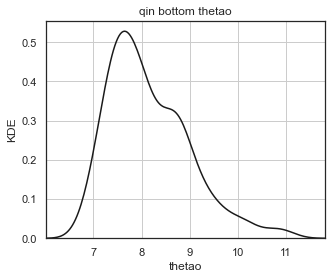

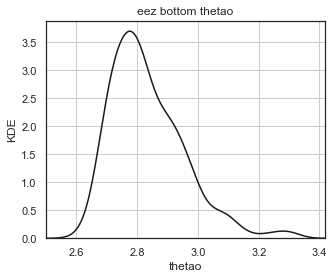

In [158]:
regionlist=["qin","eez"]
p1_s ='1993-01-01'
p1_e='2019-12-31'

p2_s ='2020-01-01'
p2_e='2040-12-31'

p3_s ='2040-01-01'
p3_e='2060-12-31'
#plot observed histogram and get the values
sns.set(style="white", palette="muted", color_codes=True)

obs_x=np.zeros(shape=(len(regionlist),200))
obs_x[:] = np.nan
obs_y=np.zeros(shape=(len(regionlist),200))
obs_y[:] = np.nan
obs_90=np.zeros(shape=(len(regionlist)))
obs_90[:]=np.nan
obs_10=np.copy(obs_90)
i=0
for region in regionlist:
    if region =="qin":
        ts=qin_obs[var]
    if region == "wa":
        ts=wa_obs[var]
    if region == "shelf":
        ts=shelf_obs[var]
    if region == "eez":
        ts=eez_obs[var]

    plt.figure(figsize=(5,4))
    binw=(ts.max()-ts.min()).values/10
    #print(binw)
    lbl="obs:"+p1_s.split("-")[0]+"-"+p1_e.split("-")[0]
    nbin=np.int((max(ts)-min(ts))/binw)
    fig=sns.distplot(ts, bins=nbin, hist=False, kde_kws={"label": lbl }, color="k")  
    obs_90[i]=ts.quantile(.9)
    obs_10[i]=ts.quantile(.1)

    #getting the curve
    obs_x[i,:], obs_y[i,:] = fig.lines[0].get_data()

    #plt.yticks(fig.get_yticks(), (fig.get_yticks() * binw *100).round(0))
    plt.grid(True)
    plt.ylabel('KDE')
    plt.title(region+' '+svar)
    plt.autoscale(enable=True, axis='x', tight=True)

    plt.show()
    i+=1

In [159]:
obs_10,obs_90

(array([7.24904735, 2.7022816 ]), array([9.24949232, 2.98220629]))

qin


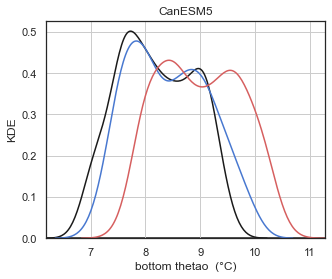

model no.1


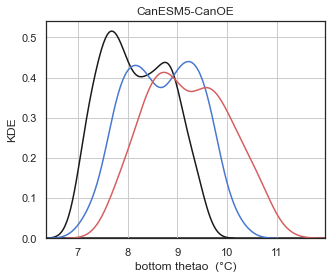

model no.2


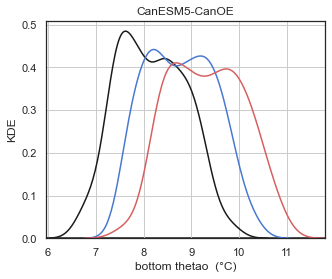

model no.3


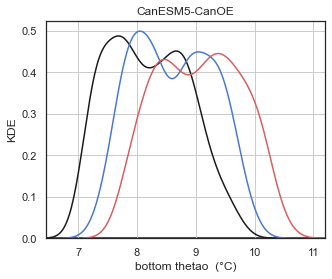

model no.4


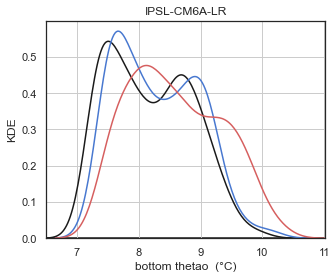

model no.5


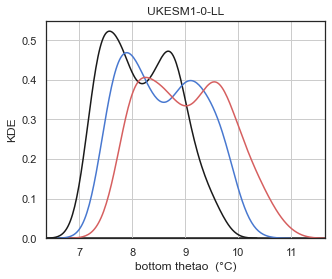

model no.6


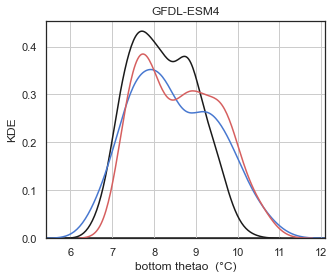

model no.7


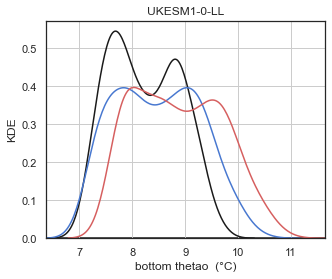

model no.8


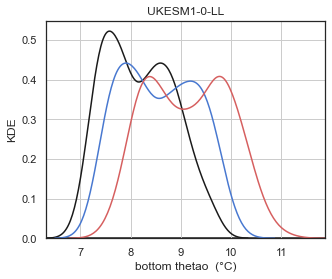

model no.9
eez


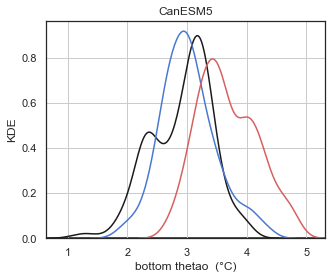

model no.1


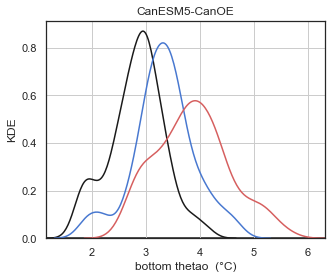

model no.2


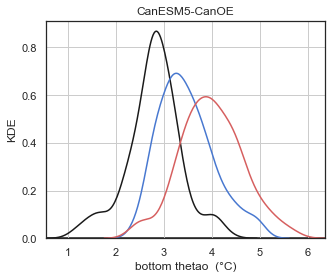

model no.3


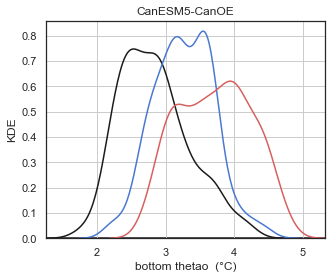

model no.4


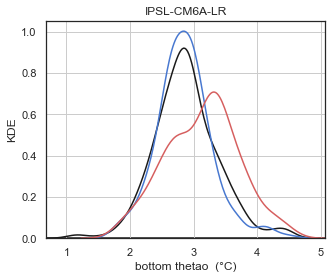

model no.5


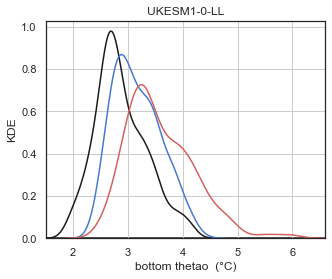

model no.6


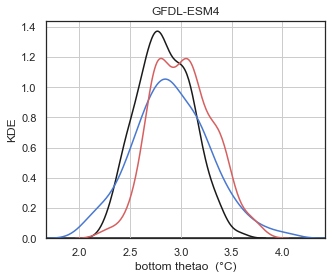

model no.7


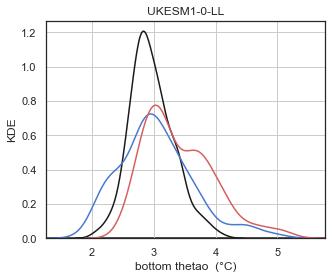

model no.8


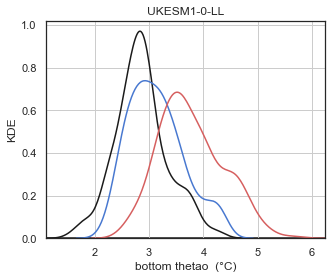

model no.9


In [160]:
# calculate model PDFs and ensemble them

p1_s ='1993-01-01'
p1_e='2019-12-31'

p2_s ='2020-01-01'
p2_e='2040-12-31'

p3_s ='2040-01-01'
p3_e='2060-12-31'

p1_x=np.zeros(shape=(len(regionlist),nbr_mdl,200))
p1_x[:] = np.nan
p1_y=np.copy(p1_x)
p2_x=np.copy(p1_x)
p2_y=np.copy(p1_x)
p3_x=np.copy(p1_x)
p3_y=np.copy(p1_x)

p1_90=np.zeros(shape=(len(regionlist),nbr_mdl))
p1_90[:]=np.nan
p1_10=np.copy(p1_90)
p3_90=np.copy(p1_90)
p3_10=np.copy(p1_90)

k=0
for region in regionlist:
    if region =="qin":
        Target=qin_mdl
    if region == "wa":
        Target=wa_mdl
    if region == "shelf":
        Target=shelf_mdl
    if region == "eez":
        Target=eez_mdl  
        
    p1=Target.sel(time=slice(p1_s , p1_e))
    p2=Target.sel(time=slice(p2_s , p2_e))
    p3=Target.sel(time=slice(p3_s , p3_e))
    
    print(region) 
    for i in range (nbr_mdl):
        mdl=str(Target.model[i].values)
        sns.set(style="white", palette="muted", color_codes=True)

        # Plot a PDF (kernel density estimate ) plot

        plt.figure(figsize=(5,4))

        minn=np.min([p1[i].min(),p2[i].min(),p3[i].min()])
        maxx=np.max([p1[i].max(),p2[i].max(),p3[i].max()])
        binw=(maxx-minn)/10

        #PERIOD 1
        TS=p1[i]
        lbl=mdl+p1_s.split("-")[0]+"-"+p1_e.split("-")[0]+")"
        nbin=np.int((TS.max()-TS.min())/binw)
        sns.distplot(TS, bins=nbin, hist=False,kde_kws={"label": lbl}, color="k") 
        p1_90[k,i]=TS.quantile(.9)
        p1_10[k,i]=TS.quantile(.1)

        #PERIOD 2
        TS=p2[i]
        lbl=mdl+p2_s.split("-")[0]+"-"+p2_e.split("-")[0]+")"
        nbin=np.int((TS.max()-TS.min())/binw)
        fig=sns.distplot(TS, bins=nbin, hist=False, kde_kws={"label": lbl}, color="b")  #, ax=axes[0, 0])

        #PERIOD 3
        TS=p3[i]
        lbl=mdl+p3_s.split("-")[0]+"-"+p3_e.split("-")[0]+")"
        nbin=np.int((TS.max()-TS.min())/binw)
        fig=sns.distplot(TS, bins=nbin, hist=False, kde_kws={"label": lbl}, color="r")  #, ax=axes[0, 0])
        p3_90[k,i]=TS.quantile(.9)
        p3_10[k,i]=TS.quantile(.1)

        p1_x[k,i,:], p1_y[k,i,:] = fig.lines[0].get_data()
        p2_x[k,i,:], p2_y[k,i,:] = fig.lines[1].get_data()
        p3_x[k,i,:], p3_y[k,i,:] = fig.lines[2].get_data()
        #print(data_x.shape, data_y.shape )
        #plt.yticks(fig.get_yticks(), (fig.get_yticks() * binw *100).round(0))
        plt.grid(True)
        plt.axhline(color='k',zorder=0)
        plt.ylabel('KDE')
        plt.xlabel(svar+  '  ('+units+')')
        plt.title(mdl)
        plt.autoscale(enable=True, axis='x', tight=True)

        plt.show()
        print('model no.' +str(i+1)) 
    k+=1

In [161]:
#interpolate individual pdfs for ensemble
N=200
y1 = np.zeros(shape=(len(regionlist),nbr_mdl,N))
y1[:] = np.nan
y2 = np.copy(y1)
y3 = np.copy(y1)
p1_mean_x = np.zeros(shape=(len(regionlist),N))
p1_mean_x[:] = np.nan
p2_mean_x = np.copy(p1_mean_x)
p3_mean_x = np.copy(p1_mean_x)

for k in range (len(regionlist)):
    
    xmin=np.nanmin([obs_x[k,:].min(),p1_x[k,:,:].min(),p2_x[k,:,:].min(),p3_x[k,:,:].min()])
    xmax=np.nanmax([obs_x[k,:].max(),p1_x[k,:,:].max(),p2_x[k,:,:].max(),p3_x[k,:,:].max()])

    xi = np.linspace(xmin, xmax, num=N)
    print(xmin,xmax)
    
    for i in range (nbr_mdl):
        y1[k,i,:] = np.interp(xi,p1_x[k,i,:], p1_y[k,i,:])
        y2[k,i,:] = np.interp(xi,p2_x[k,i,:], p2_y[k,i,:])
        y3[k,i,:] = np.interp(xi,p3_x[k,i,:], p3_y[k,i,:])

    p1_mean_x[k,:] =xi
    p2_mean_x[k,:] =xi
    p3_mean_x[k,:] =xi

y1= xr.DataArray(y1,                                 
          name=var,             
          coords={'region': regionlist,'model':model_name,'interval':range(1,N+1)},    
          dims=('region','model','interval') )
y2= xr.DataArray(y2,                                 
          name=var,             
          coords={'region': regionlist,'model':model_name,'interval':range(1,N+1)},    
          dims=('region','model','interval') )
y3= xr.DataArray(y3,                                 
          name=var,             
          coords={'region': regionlist,'model':model_name,'interval':range(1,N+1)},    
          dims=('region','model','interval') )
#print(y3)
#UKESM1 LE
p1_le_y=y1.sel(model='UKESM1-0-LL').mean('model')
p2_le_y=y2.sel(model='UKESM1-0-LL').mean('model')
p3_le_y=y3.sel(model='UKESM1-0-LL').mean('model')
#MME
#NN=nbr_mdl-len(y1.sel(model='UKESM1-0-LL').model)+1
p1_mme_y=y1.mean('model')#[:,0:NN,:].mean('model')
p2_mme_y=y2.mean('model')#[:,0:NN,:].mean('model')
p3_mme_y=y3.mean('model')#[:,0:NN,:].mean('model')

#print(p3_le_y)

obs_interp_y=np.zeros(shape=(len(regionlist),N))
obs_interp_y[:] = np.nan
obs_interp_x=np.copy(obs_interp_y)
for k in range (len(regionlist)):
    xi = p1_mean_x[k,:]
    obs_interp_y[k,:] = np.interp(xi,obs_x[k,:], obs_y[k,:]) 
    obs_interp_x[k,:] = xi

5.416637374823894 12.091061855837598
0.5486226317898636 6.5929991602880875


In [162]:
p1_90_mme=np.mean(p1_90,axis=1)
p1_10_mme=np.mean(p1_10,axis=1)
p3_90_mme=np.mean(p3_90,axis=1)
p3_10_mme=np.mean(p3_10,axis=1)

qin


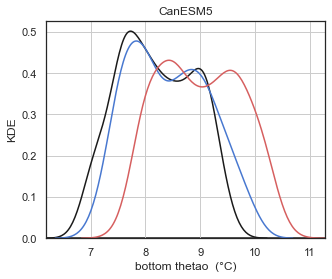

model no.1


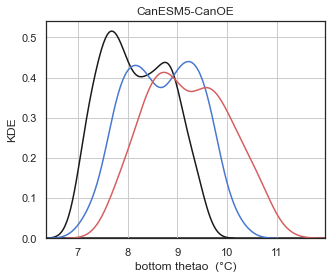

model no.2


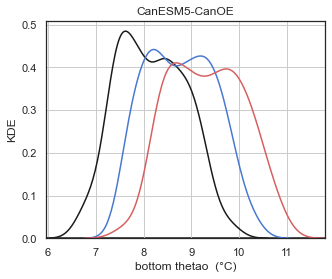

model no.3


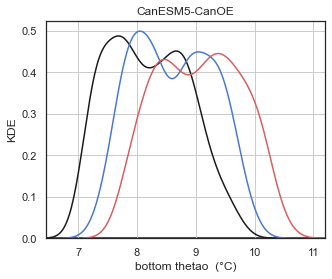

model no.4


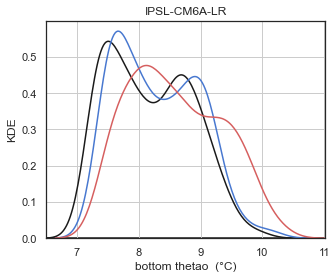

model no.5
eez


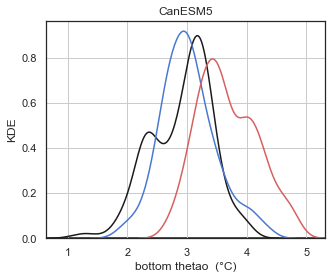

model no.1


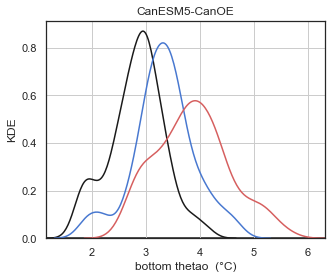

model no.2


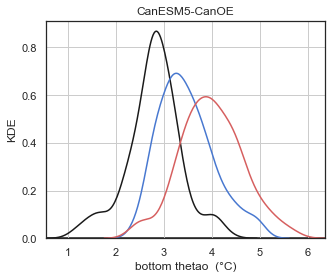

model no.3


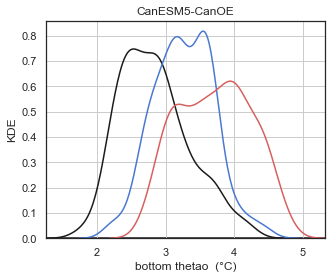

model no.4


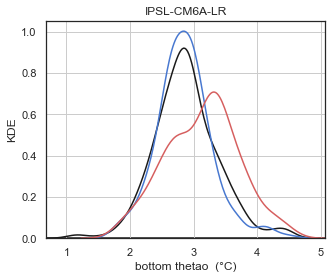

model no.5


In [163]:
# calculate model PDFs and ensemble them

p1_s ='1993-01-01'
p1_e='2019-12-31'

p2_s ='2020-01-01'
p2_e='2040-12-31'

p3_s ='2040-01-01'
p3_e='2060-12-31'

p1_x_245=np.zeros(shape=(len(regionlist),nbr_mdl_245,200))
p1_x_245[:] = np.nan
p1_y_245=np.copy(p1_x_245)
p2_x_245=np.copy(p1_x_245)
p2_y_245=np.copy(p1_x_245)
p3_x_245=np.copy(p1_x_245)
p3_y_245=np.copy(p1_x_245)

p1_90=np.zeros(shape=(len(regionlist),nbr_mdl_245))
p1_90[:]=np.nan
p1_10=np.copy(p1_90)
p3_90=np.copy(p1_90)
p3_10=np.copy(p1_90)

k=0
for region in regionlist:
    if region =="qin":
        Target=qin_mdl
    if region == "wa":
        Target=wa_mdl
    if region == "shelf":
        Target=shelf_mdl
    if region == "eez":
        Target=eez_mdl  
        
    p1=Target.sel(time=slice(p1_s , p1_e))
    p2=Target.sel(time=slice(p2_s , p2_e))
    p3=Target.sel(time=slice(p3_s , p3_e))
    
    print(region) 
    for i in range (nbr_mdl_245):
        mdl=str(Target.model[i].values)
        sns.set(style="white", palette="muted", color_codes=True)

        # Plot a PDF (kernel density estimate ) plot

        plt.figure(figsize=(5,4))

        minn=np.min([p1[i].min(),p2[i].min(),p3[i].min()])
        maxx=np.max([p1[i].max(),p2[i].max(),p3[i].max()])
        binw=(maxx-minn)/10

        #PERIOD 1
        TS=p1[i]
        lbl=mdl+p1_s.split("-")[0]+"-"+p1_e.split("-")[0]+")"
        nbin=np.int((TS.max()-TS.min())/binw)
        sns.distplot(TS, bins=nbin, hist=False,kde_kws={"label": lbl}, color="k") 
        p1_90[k,i]=TS.quantile(.9)
        p1_10[k,i]=TS.quantile(.1)

        #PERIOD 2
        TS=p2[i]
        lbl=mdl+p2_s.split("-")[0]+"-"+p2_e.split("-")[0]+")"
        nbin=np.int((TS.max()-TS.min())/binw)
        fig=sns.distplot(TS, bins=nbin, hist=False, kde_kws={"label": lbl}, color="b")  #, ax=axes[0, 0])

        #PERIOD 3
        TS=p3[i]
        lbl=mdl+p3_s.split("-")[0]+"-"+p3_e.split("-")[0]+")"
        nbin=np.int((TS.max()-TS.min())/binw)
        fig=sns.distplot(TS, bins=nbin, hist=False, kde_kws={"label": lbl}, color="r")  #, ax=axes[0, 0])
        p3_90[k,i]=TS.quantile(.9)
        p3_10[k,i]=TS.quantile(.1)

        p1_x_245[k,i,:], p1_y_245[k,i,:] = fig.lines[0].get_data()
        p2_x_245[k,i,:], p2_y_245[k,i,:] = fig.lines[1].get_data()
        p3_x_245[k,i,:], p3_y_245[k,i,:] = fig.lines[2].get_data()
        #print(data_x.shape, data_y.shape )
        #plt.yticks(fig.get_yticks(), (fig.get_yticks() * binw *100).round(0))
        plt.grid(True)
        plt.axhline(color='k',zorder=0)
        plt.ylabel('KDE')
        plt.xlabel(svar+  '  ('+units+')')
        plt.title(mdl)
        plt.autoscale(enable=True, axis='x', tight=True)

        plt.show()
        print('model no.' +str(i+1)) 
    k+=1

In [164]:
#interpolate individual pdfs for ensemble
N=200
y1 = np.zeros(shape=(len(regionlist),nbr_mdl_245,N))
y1[:] = np.nan
y2 = np.copy(y1)
y3 = np.copy(y1)
p1_mean_x_245 = np.zeros(shape=(len(regionlist),N))
p1_mean_x_245[:] = np.nan
p2_mean_x_245 = np.copy(p1_mean_x_245)
p3_mean_x_245 = np.copy(p1_mean_x_245)

for k in range (len(regionlist)):
    
    xmin=np.nanmin([obs_x[k,:].min(),p1_x_245[k,:,:].min(),p2_x_245[k,:,:].min(),p3_x_245[k,:,:].min()])
    xmax=np.nanmax([obs_x[k,:].max(),p1_x_245[k,:,:].max(),p2_x_245[k,:,:].max(),p3_x_245[k,:,:].max()])

    xi = np.linspace(xmin, xmax, num=N)
    print(xmin,xmax)
    
    for i in range (nbr_mdl_245):
        y1[k,i,:] = np.interp(xi,p1_x_245[k,i,:], p1_y_245[k,i,:])
        y2[k,i,:] = np.interp(xi,p2_x_245[k,i,:], p2_y_245[k,i,:])
        y3[k,i,:] = np.interp(xi,p3_x_245[k,i,:], p3_y_245[k,i,:])

    p1_mean_x_245[k,:] =xi
    p2_mean_x_245[k,:] =xi
    p3_mean_x_245[k,:] =xi

y1= xr.DataArray(y1,                                 
          name=var,             
          coords={'region': regionlist,'model':model_name_245,'interval':range(1,N+1)},    
          dims=('region','model','interval') )
y2= xr.DataArray(y2,                                 
          name=var,             
          coords={'region': regionlist,'model':model_name_245,'interval':range(1,N+1)},    
          dims=('region','model','interval') )
y3= xr.DataArray(y3,                                 
          name=var,             
          coords={'region': regionlist,'model':model_name_245,'interval':range(1,N+1)},    
          dims=('region','model','interval') )

#MME
#NN=nbr_mdl-len(y1.sel(model='UKESM1-0-LL').model)+1
p1_mme_y_245=y1.mean('model')#[:,0:NN,:].mean('model')
p2_mme_y_245=y2.mean('model')#[:,0:NN,:].mean('model')
p3_mme_y_245=y3.mean('model')#[:,0:NN,:].mean('model')



5.959014731534096 11.965591568298374
0.5486226317898636 6.365061184318625


In [165]:
p1_90_mme_245=np.mean(p1_90,axis=1)
p1_10_mme_245=np.mean(p1_10,axis=1)
p3_90_mme_245=np.mean(p3_90,axis=1)
p3_10_mme_245=np.mean(p3_10,axis=1)
p3_10_mme_245

array([8.04015169, 2.9258133 ])

In [166]:
df = pd.DataFrame({'obs_x':obs_interp_x[0,:],'obs_y':obs_interp_y[0,:],
                  'p1_x_245':p1_mean_x_245[0,:],'p1_y_245':p1_mme_y_245[0,:],
                  'p2_x_245':p3_mean_x_245[0,:],'p2_y_245':p3_mme_y_245[0,:],
                  'p1_x_585':p1_mean_x[0,:],'p1_y_585':p1_mme_y[0,:],
                  'p2_x_585':p3_mean_x[0,:],'p2_y_585':p3_mme_y[0,:]})
df.to_excel(figdir+svar+'_pdf.xlsx')  

In [167]:
df = pd.DataFrame({'obs_90':obs_90[0],'obs_10':obs_10[0],
                  'p1_90_245':p1_90_mme_245[0],'p1_10_245':p1_10_mme_245[0],
                  'p2_90_245':p3_90_mme_245[0],'p2_10_245':p1_10_mme_245[0],
                  'p1_90_585':p1_90_mme[0],'p1_10_585':p1_10_mme[0],
                  'p2_90_585':p3_90_mme[0],'p2_10_585':p3_10_mme[0]},index=range(1))
df.to_excel(figdir+svar+'_thresholds.xlsx')  

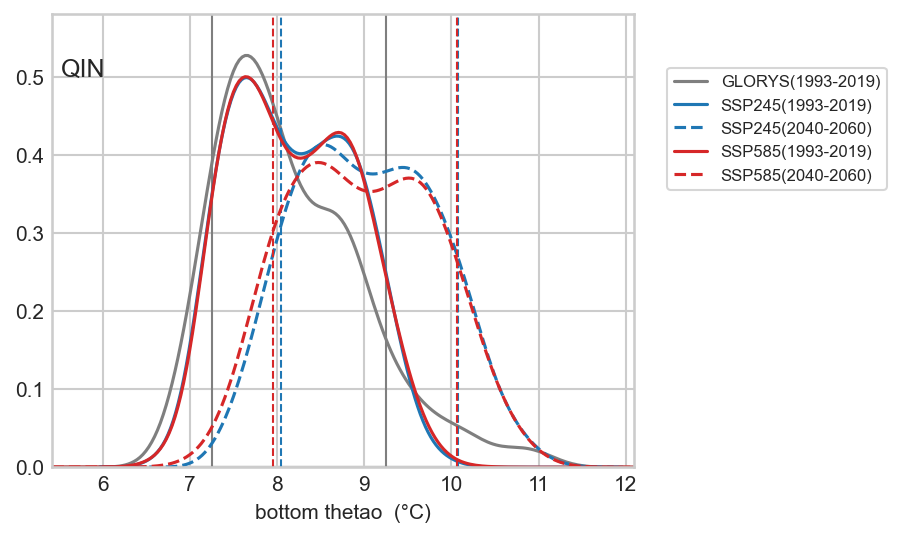

In [168]:
#sns.set(style="white", palette="muted", color_codes=True)
sns.set(style="whitegrid",palette="tab10")
regionlist=["qin"]#,"eez"]
#for thetao
colors = [plt.cm.tab10(0),plt.cm.tab20(1),plt.cm.tab10(3),
          plt.cm.tab20(7),plt.cm.tab10(7)]
#for o2
#colors = [plt.cm.tab10(9),plt.cm.tab20(17),plt.cm.tab10(1),
#         plt.cm.tab20(3),plt.cm.tab10(7)]

from matplotlib import gridspec

fig=plt.figure(figsize=(7,4),dpi=150)
gs = gridspec.GridSpec(1, 2, width_ratios=[3,1]) 
gs.update(wspace=0.1, hspace=0.17) 


k=0
for region in regionlist:

    ax = plt.subplot(gs[k])
    #obs
    lbl='GLORYS'+"("+p1_s.split("-")[0]+"-"+p1_e.split("-")[0]+")"
    ax.plot(obs_interp_x[k,:], obs_interp_y[k,:],color=colors[4],label=lbl)    
    
    plt.axvline(x=obs_90[k],color=colors[4],linewidth=1)#,linestyle='dashed')
    plt.axvline(x=obs_10[k],color=colors[4],linewidth=1)#,linestyle='dashed')
    
    #PERIOD 1
    lbl='SSP245'+"("+p1_s.split("-")[0]+"-"+p1_e.split("-")[0]+")"
    ax.plot(p1_mean_x_245[k,:], p1_mme_y_245[k,:],color=colors[0],label=lbl)
    ##PERIOD 2
    #lbl='SSP245'+"("+p2_s.split("-")[0]+"-"+p2_e.split("-")[0]+")"
    #ax.plot(p2_mean_x_245[k,:], p2_mme_y_245[k,:],color='b',label=lbl)
    #PERIOD 3
    lbl='SSP245'+"("+p3_s.split("-")[0]+"-"+p3_e.split("-")[0]+")"
    ax.plot(p3_mean_x_245[k,:], p3_mme_y_245[k,:],color=colors[0],label=lbl,linestyle='dashed')
    
    plt.axvline(x=p3_90_mme_245[k],color=colors[0],linewidth=1,linestyle='dashed')
    plt.axvline(x=p3_10_mme_245[k],color=colors[0],linewidth=1,linestyle='dashed')

    #PERIOD 1
    lbl='SSP585'+"("+p1_s.split("-")[0]+"-"+p1_e.split("-")[0]+")"
    ax.plot(p1_mean_x[k,:], p1_mme_y[k,:],color=colors[2],label=lbl)
    ##PERIOD 2
    #lbl='SSP585'+"("+p2_s.split("-")[0]+"-"+p2_e.split("-")[0]+")"
    #ax.plot(p2_mean_x[k,:], p2_mme_y[k,:],color='r',label=lbl)
    #PERIOD 3
    lbl='SSP585'+"("+p3_s.split("-")[0]+"-"+p3_e.split("-")[0]+")"
    ax.plot(p3_mean_x[k,:], p3_mme_y[k,:],color=colors[2],label=lbl,linestyle='dashed')
    
    plt.axvline(x=p3_90_mme[k],color=colors[2],linewidth=1,linestyle='dashed')
    plt.axvline(x=p3_10_mme[k],color=colors[2],linewidth=1,linestyle='dashed')   

    plt.grid(True)
    plt.axhline(color='k',zorder=0)
    plt.xlabel(svar+  '  ('+units+')',fontsize=10)
    up=np.max([obs_interp_y[k,:],p1_mme_y[k,:],p2_mme_y[k,:],p3_mme_y[k,:]])
    left=np.min([obs_interp_x[k,:],p3_mean_x[k,:]])
    
    plt.text(left+0.1, up*.95,region.upper())
                  # bbox=dict(  #boxstyle="round",
                  # ec=(1., 0.5, 0.5),
                  # fc=(1., 0.8, 0.8)))
    plt.autoscale(enable=True, axis='x', tight=True)
    ax.tick_params(axis='both', which='major', pad=-2,labelsize=10)
    ax.set_ylim(0,np.max([obs_interp_y[k,:],p1_mme_y[k,:],p2_mme_y[k,:],p3_mme_y[k,:]])*1.1)
    #plt.yticks([])
    if k==0:
        plt.legend(fontsize=8,loc='upper right', bbox_to_anchor=(1.45, .9))#,ncol=2)

    k+=1

plt.savefig(figdir+svar+'_pdf_lines.png',dpi=300, bbox_inches = "tight")
plt.tight_layout()
plt.show()